In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [5]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.5.0


In [6]:
base_dir = "C://Users//aiswa//Downloads//deeplearningalzheimers//Alzheimer_s Dataset//"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [46]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [40]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6400, shuffle=False)

Found 6400 images belonging to 4 classes.


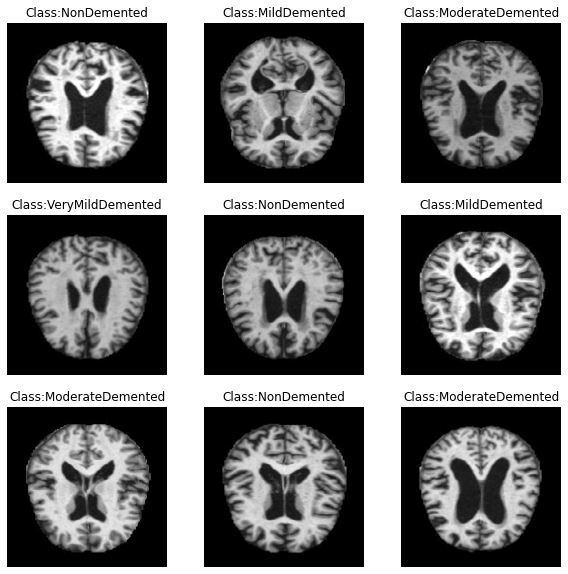

In [9]:
def show_images(generator,y_pred=None):
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
     # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
            
# Display Train Images
show_images(train_data_gen)

In [10]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [11]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [12]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
import imblearn
print(imblearn.__version__)

0.8.0


In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [51]:
import os
from os import listdir
datasetfiles = listdir(WORK_DIR)
print(len(datasetfiles))

#Calculating total numer of images in Train and Test Data
total_images = 0
total_images_infolder=0
total_images_folder=0
base_path='./dataset'
for i in range(len(datasetfiles)):
        class_folder=datasetfiles[i]
        class_path = base_path + '/' + class_folder + '/'
        sub_files = listdir(class_path)
        total_images_infolder += len(sub_files)
        total_images_folder+= len(sub_files)
        print("Total Images in ",class_folder,"is",total_images_infolder)
        total_images_infolder=0
print(total_images_folder)


4
Total Images in  MildDemented is 896
Total Images in  ModerateDemented is 64
Total Images in  NonDemented is 3200
Total Images in  VeryMildDemented is 2240
6400


In [50]:
print(len(datasetfiles))

5


In [48]:
pwd

'C:\\Users\\aiswa'

In [16]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


# InceptionV3 Net

In [17]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [18]:
for layer in inception_model.layers:
    layer.trainable=False

In [19]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")


In [20]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [23]:
import tensorflow as tf
import tensorflow_addons as tfa

In [24]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)       

In [26]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 10

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
256/256 [==============================] - 173s 677ms/step - loss: 0.8631 - acc: 0.6045 - auc: 0.8629 - f1_score: 0.5971 - val_loss: 0.6426 - val_acc: 0.6973 - val_auc: 0.9219 - val_f1_score: 0.6812
Epoch 2/10
256/256 [==============================] - 179s 698ms/step - loss: 0.7633 - acc: 0.6517 - auc: 0.8935 - f1_score: 0.6425 - val_loss: 0.5962 - val_acc: 0.7319 - val_auc: 0.9349 - val_f1_score: 0.7290
Epoch 3/10
256/256 [==============================] - 183s 715ms/step - loss: 0.7158 - acc: 0.6742 - auc: 0.9065 - f1_score: 0.6719 - val_loss: 0.5656 - val_acc: 0.7476 - val_auc: 0.9410 - val_f1_score: 0.7447
Epoch 4/10
256/256 [==============================] - 181s 705ms/step - loss: 0.6779 - acc: 0.6982 - auc: 0.9170 - f1_score: 0.6954 - val_loss: 0.5438 - val_acc: 0.7607 - val_auc: 0.9468 - val_f1_score: 0.7578
Epoch 5/10
256/256 [==============================] - 185s 722ms/step - loss: 0.6369 - acc: 0.7166 - auc: 0.9267 - f1_score: 0.7164 - val_loss: 0.5321 - val_acc

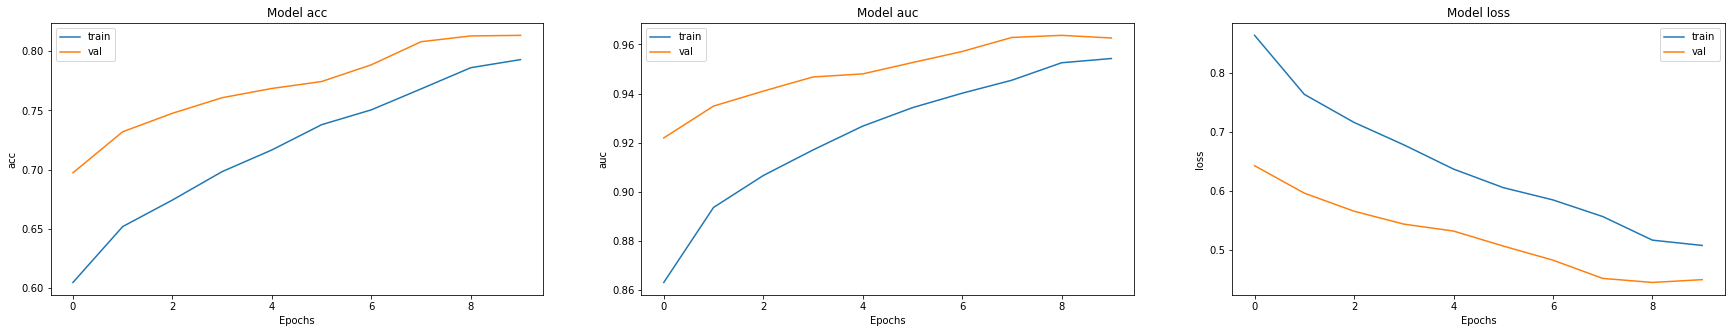

In [27]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (10, 30))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [28]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 42s 530ms/step - loss: 0.4515 - acc: 0.8098 - auc: 0.9629 - f1_score: 0.8060
Testing Accuracy: 80.98%


In [29]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

In [30]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.79      0.92      0.85       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.74      0.70      0.72       662
ModerateDemented       0.70      0.61      0.65       624

       micro avg       0.81      0.81      0.81      2560
       macro avg       0.81      0.81      0.81      2560
    weighted avg       0.81      0.81      0.81      2560
     samples avg       0.81      0.81      0.81      2560



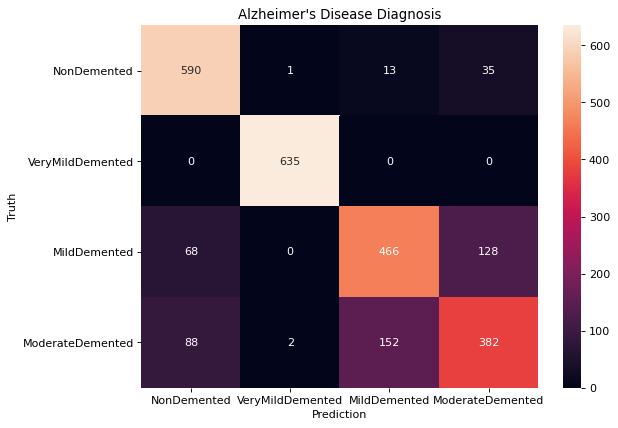

In [33]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)


In [37]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 80.99 %
